In [1]:
%load_ext autoreload
%autoreload 2

# Merging everything together, without MonteCarlo sims

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
import copy
import os, sys

import brian2 as b2
import neurom as nm
import pyrho as pr

import warnings

from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi
from allensdk.core.cell_types_cache import ReporterStatus as RS

warnings.filterwarnings('ignore')
b2.prefs.codegen.target = 'numpy' #PyRhO has weird zerodiv with Cython Brian

In [3]:
# thanks https://stackoverflow.com/questions/8391411/suppress-calls-to-print-python
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Parameters

In [4]:
### Morphological parameters
# Relative percentage of E/I cells
frac_exc = .85
frac_inh = 1.-frac_exc

# Layer median thickness (um)
layer_thickness = {1 : 100,
                  2 : 210,
                  4 : 120,
                  5 : 220,
                  6 : 200}

# Cell counts per layer (scaled)
density_scale = .001
layer_density = {1 : 0 * density_scale,
                2 : 65949 * density_scale,
                4 : 53837 * density_scale,
                5 : 39480 * density_scale,
                6 : 67296 * density_scale}

# Layer morphotypes {layer : [(type, fraction)]}
layer_morphology = {1 : [('NO CELLS', .0)],
                    2 : [('Cux2', 1.)],
                    4 : [('Scnn1a', .3),
                         ('Rorb', .25),
                         ('Nr5a1', .12)],
                    5 : [('Rbp4', 1.)],
                    6 : [('Ntsr1', .8)]}

# Morphology files save path
morpho_path = '../morphologies/'

In [5]:
### Network parameters
# Defining the ChR2 model
n_states = '3' #number of states in the channel model : 3, 4 or 6
params = pr.modelFits[n_states]['ChR2'] #only ChR2 seems to be pre-packed with pyrho

# Defining the pyrho model
rho = pr.models[n_states](params)

# Defining the equations
netParams = {'tau_m':10*b2.ms,
             'R_m':70*b2.Mohm,
             'E_m':-70*b2.mV,
             'v_t0':-50*b2.mV,
             'sigma':10*b2.mV,
             't_ref':4*b2.ms}
eq_opto = '''
dv/dt = ((-I*R_m)+E_m-v)/tau_m + sigma*xi*tau_m**-0.5 : volt
''' + rho.brian_phi_t # writes the model in a brian-interpretable string
eq_norm = '''
dv/dt = (E_m-v)/tau_m + sigma*xi*tau_m**-0.5 : volt
'''

sim_duration = 150 # ms, length of the simulation

In [6]:
### Physical model parameters
n_voxels = 10 # nbr of voxels along one axis (so n_voxels^3 total)
voxel_size = 101 #um, size of a voxel

# Fetching data from Allen DB

In [7]:
# Initiates the CellTypes constructor
ctc = CellTypesCache(morpho_path) 

# Get all reconstructed mice neurons
cells = ctc.get_cells(require_reconstruction = True, 
                      species=[CellTypesApi.MOUSE])

# Filter cells to keep only V1 neurons with a specific names
layer_dict = {1 : [], 2 : [], 4 : [], 5 : [], 6 : []}
for cell in tqdm(cells, total = len(cells), desc = 'Fetching cells...') :
    if cell['structure_area_abbrev'] == 'VISp':
        layer = int(cell['structure_layer_name'][0]) #[0] eliminates the 2/3, 6a, 4b...
        morphotypes = layer_morphology[layer] # get the layer morphotypes names
        for types in morphotypes :
            if types[0] in cell['name'] :
                morpho = ctc.get_reconstruction(specimen_id = cell['id'],
                                            file_name = morpho_path + cell['name']  + '.swc')
                layer_dict[layer].append([cell['name'], cell['id'], morpho, morpho_path + cell['name']  + '.swc' ])
    else :
        pass
    
layer_array = {1 : [], 2 : [], 4 : [], 5 : [], 6 : []}
for layer, items in tqdm(layer_dict.items(), total = len(layer_dict), desc = 'Loading and shuffling morphologies') :
    _ = []
    for morph_tuples in layer_morphology[layer] :
        name_morpho, fract_morpho = morph_tuples[0], morph_tuples[1]
        
        n_cells = fract_morpho * layer_density[layer]
        
        morpholist = [nm.load_neuron(x[-1]) for x in layer_dict[layer] if name_morpho in x[0]]
        morphonames = [x[0] for x in layer_dict[layer] if name_morpho in x[0]]
        morph_array = np.resize(morpholist, int(n_cells))
        np.random.shuffle(morph_array)
        
        _.append(morph_array)
    layer_array[layer].append(np.concatenate(_))

Loading and shuffling morphologies: 100%|████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.17it/s]


# Simulating a random voxel matrix 

In [8]:
X, Y, Z = np.mgrid[0 : n_voxels * voxel_size: np.complex(n_voxels),
                   0 : n_voxels * voxel_size: np.complex(n_voxels),
                   0 : -n_voxels * voxel_size: np.complex(n_voxels)]
voxel_matrix = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])

light_matrix = np.random.random_sample(size = (n_voxels, n_voxels, n_voxels))

# Relocating cells into their respective layers and simulating

In [9]:
curr_z = 0  # depth, iterates negatively layer by layer

results_dict = {1 : [], 2 : [], 4 : [], 5 : [], 6 : []}
for layer, items in layer_array.items():
    if layer == 1 : continue # No neurons in layer1
        
    # Aliasing, array of all neuromorph objects
    layer_content = items[0]

    # Coordinates of the layer's neurons, X and Y
    safety_margin = n_voxels * voxel_size / np.sqrt(len(layer_content))
    xs = np.arange(0, n_voxels * voxel_size, safety_margin)
    ys = np.arange(0, n_voxels * voxel_size, safety_margin)
    xx, yy = np.meshgrid(xs, ys)
    mesh = np.dstack([xx, yy]).reshape(-1, 2)
    
    # In the Z axis
    zs = np.linspace(0., .75, 5, endpoint = False)
    if zs.size == 0: zs = np.array([0], dtype=np.int16)
    
    
    # Iterating through neurons in the layer, gettings the xyz coordinates
    for i0, _ in tqdm(enumerate(layer_content), total = len(layer_content),
                               desc = 'Simulating layer %s neurons...' % layer) :
        x = mesh[i0][0]
        y = mesh[i0][1]
        z = np.random.choice(zs) * layer_thickness[layer] + curr_z
        points = layer_content[i0].points
        pts_list = []
        for pts in points :
            pts_list.append([ x+ pts[0], y + pts[1], z + pts[2]])
            
        # Getting the light value for each point
        light_vals = []
        for pt in pts_list :
            vox_idx = np.int16(np.abs(np.array(pt) / (voxel_size*n_voxels)))
            light_vals.append(light_matrix[vox_idx[0], vox_idx[1], vox_idx[2]])
        total_light = np.sum(light_vals)
          
        # Start the simulation scope    
        b2.start_scope()
        
        # Defining the stimulation protocol 
        protocol = pr.protocols['step']()
        protocol.phis = [total_light*1e15] #photons <------ improve this
        protocol.Vs = [None]
        protocol.cycles = [[sim_duration, 0]] #on-off times
        
        # Defining the neuron
        neuron = b2.NeuronGroup(1, eq_opto, threshold='v>v_t0', reset='v=E_m', refractory='t_ref', 
                                namespace=netParams, name='Inputs', method='euler')

        # Set up the recording
        net = b2.Network(b2.collect())
        monitors = {'states' : b2.StateMonitor(neuron, rho.brianStateVars, record=0),   # Record states
                    'I'      : b2.StateMonitor(neuron, 'I', record=0),                  # Record current
                    'V'      : b2.StateMonitor(neuron, 'v', record=0),                  # Record voltage, 
                    'spikes' : [b2.SpikeMonitor(neuron, name='neuron')]}
        net.add(monitors)

        # And here we go
        sim = pr.simulators['Brian'](protocol, 
                                    rho, 
                                    pr.simParams['Brian'],
                                    net,
                                    netParams,
                                    monitors)
        with HiddenPrints(): # no damn verbosity control on this guy
            sim.run(verbose = 0)
            
        # Save the variables
        results_dict[layer].append({'photons' : total_light,
                                  'spikes' : monitors['spikes'][0].spike_trains()})

    # Updating layer depth and moving to next layer
    curr_z -= layer_thickness[layer]

Simulating layer 6 neurons...: 100%|███████████████████████████████████████████████████| 53/53 [00:17<00:00,  3.10it/s]


# Seeing some results

In [10]:
for layer, r_list in results_dict.items() :
    trains = [x['spikes'] for x in r_list]

In [11]:
trains[0]

{0: array([  0. ,  25.8,  29.8,  33.8,  37.8,  41.8,  45.8,  49.8,  53.8,
         57.8,  61.8,  65.8,  69.8,  73.8,  77.8,  81.8,  85.8,  89.8,
         93.8,  97.8, 101.8, 105.8, 109.8, 113.8, 117.8, 121.8, 125.8,
        129.8, 133.8, 137.8, 141.8, 145.8, 149.8, 153.8, 157.8, 161.8,
        165.8, 169.8, 173.8]) * msecond}

In [12]:
spikemon.sp

NameError: name 'spikemon' is not defined

# And plotting some figures

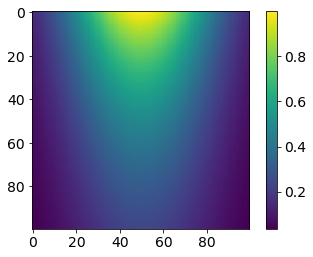

In [35]:
x = np.linspace(0,10,100)
y = np.linspace(0,5,100)
X, Y = np.meshgrid(x, y)
f = np.exp(-X/7.) * np.exp(-((Y-2.5)/1.8)**2)
f = np.rot90(f, 3)

fig, ax = plt.subplots()
i = ax.imshow(f)
plt.colorbar(i)
plt.show()